We consider a pure exchange economy with $N$ agents and $n$ commodities.
Each agent $i$ has an endowment $e_i \in {\bf{R}}_+^n$ and a utility 
function $U_i(r_i)$, where $U_i: {\bf{R}}_+^n \to {\bf{R}}$ is a concave nondecreasing. These primitives define the exchange economy $\mathcal{E}=\left( (U_i, e_i)_{i \in [N]}\right)$. Denote the total endowment by $E = \sum_{i=1}^N e_i$.


**Walrasian equilibrium** for exchange economy $\mathcal{E}$ is a vector $\left( \nu, (x_i)_{i \in [N]}\right)$, such that 
* every agent's consumption  $x_i\in {\bf{R}}^n$ maximizes her utility given prices $\nu \in {\bf{R}}_+^n$
$$
\begin{array}{ll}
\mbox{maximize} & U_i(x_i)  \\
\mbox{subject to} & \nu^T x_i \leq \nu^T e_i \\
& x_i \geq  0,
\end{array}
$$
* markets clear $\sum_{i=1}^N x_i \leq \sum_{i=1}^N e_i=E$.

The goal of this notebook is to see the performance of OSBDO when applied to the action directed Walrasian Equilibrium (over primal variables $x_1, \ldots, x_N$) and price directed Walrasian Equilibrium (over dual variable $\nu$). This corresponds to the primal formulation of the problem, given by
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N -U_i(x_i)  \\
\mbox{subject to} & \sum_{i=1}^N x_i = E \\
& x_i  \geq 0, \quad i=1,\ldots, N,
\end{array}
$$
and negated dual formulation of the problem, given by  
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N \underset{x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ) + \nu_1^T E   \\
\mbox{subject to} & \nu_1=\cdots=\nu_N.
\end{array}
$$


In [1]:
import cvxpy as cp
import numpy as np
import osbdo as ob

from scipy import stats
import time
from scipy import stats

In [2]:
import matplotlib.pyplot as plt

In [3]:
def get_rel_diff(a,b):
    return np.linalg.norm(a-b) / min(np.linalg.norm(a), np.linalg.norm(b)) 

In [4]:
def check_subgrads(agent, ntimes):
    l, u = agent.lwb, agent.upb
    n = agent.dim
    for _ in range(ntimes):
        v = l + np.multiply(np.random.rand(n), u-l)
        point = agent.query(v=v)
        linear = lambda x: point.f + point.q @ (x - point.x)
        for _ in range(10):
            test = l + np.multiply(np.random.rand(n), u-l)
            a = linear(test)
            b = agent.query(v=test).f + 10**(-6)
            assert a <= b, print(a, b, b-a)
    print("passed")

# Create instance of the problem

In [5]:
N = 50

params, R = ob.ra_params(num_resources=N, num_agents=N, num_participants=N)

In [6]:
E = R
n = params[0]['dimension']

In [7]:
for j in range(n):
    count = 0
    for i in range(N):
        A = params[i]["A_list"][0]
        if A[0,j] > 0:
            count += 1
    assert count > 0

# Centralized solution

In [9]:
dim = params[0]['dimension']
z = cp.Variable(len(params)*dim)
num_agents = len(params)
constraints = []
f = 0
xi_list = []
start = time.time()
for i in range(num_agents):
    xi = z[(i*dim):((i+1)*dim)]
    X = cp.Variable((len(params[i]['A_list']), dim))
    for j in range(len(params[i]['A_list'])):
        f += -cp.geo_mean(params[i]['A_list'][j] @ X[j].T + params[i]['b_list'][j])
    constraints += [cp.sum(X,axis=0) <= xi, \
                    X>=0, \
                    xi<=params[i]['upper_bound'], 
                    xi>=params[i]['lower_bound']]
    xi_list.append(xi)
constraints += [sum(xi_list)==R]
prob_cvx = cp.Problem(cp.Minimize(f), constraints)
prob_cvx.solve(solver='ECOS')
print(f"elapsed time =  {time.time()-start}")

h_cvx, x_cvx = f.value, z.value
nu_cvx = constraints[-1].dual_value
print(f"{h_cvx = }")

elapsed time =  1.8503921031951904
h_cvx = -441.2143119803273


### Initial upper bound on $\nu$
$$
\nu^\star_j \leq \nu_{\max,j} ~=~ \min_{i:{A_{i, \cdot j}}\neq 0 } \quad \left [ (1/m) \mbox{geomean}(A_i E + b_i) ~ A_i^T b_i^{-1} \right ]
$$

In [ ]:
nu_upb = np.inf * np.ones(n)
m = params[0]["A_list"][0].shape[0]

for i  in  range(N):
    A = params[i]["A_list"][0]
    b = params[i]["b_list"][0]
    assert (A>=0).all() and (b>=0).all()
    Ui = stats.mstats.gmean(A@E + b)
    grad_i = (Ui/m) * A.T @ b**(-1)
    
    for j in range(n):
        if A[0,j] > 0:
            nu_upb[j] = min(nu_upb[j], grad_i[j])

In [12]:
nu_cvx.min(), nu_cvx.max(), nu_upb.min(), nu_upb.max()

(225.58239566083734,
 0.605502579770611,
 0.8625884345430109,
 7.531374604706299,
 28.12139502301498)

In [13]:
assert (nu_cvx <= nu_upb + 10**(-8) ).all(), print("wrong bound on nu")

# Walrasian equilibrium: action directed
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N -U_i(x_i)  \\
\mbox{subject to} & \sum_{i=1}^N x_i = E \\
& x_i  \geq 0, \quad i=1,\ldots, N,
\end{array}
$$
where $U_i(x_i)= \mbox{geomean} \left(A_ix_i+b_i\right)$.

## OSBDO oracle-structured form 
We can solve the problem using OSBDO, by taking the agent function
$$
f_i(x_i) = -U_i(x_i),$$
and the structured objective function $g$,
$$
g(x) = \left\{ \begin{array}{ll} 0 &
x_1 + \cdots + x_N = E, \quad x_i \geq 0, \quad i=1, \ldots, N\\
\infty & \mbox{otherwise}.
\end{array} \right.
$$

In [15]:
rel_gap = 0.01

# OSBDO solution

In [16]:
agents = ob.ra_agents(params=params)

domain = [sum([agents[i].x for i in range(len(agents))])==R]
g = ob.Coupling(agents = agents, function = cp.Constant(0), domain = domain)

prob = ob.Problem(agents = agents, g = g)

In [18]:
start = time.time()
x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=50)
print(f"elapsed time =  {time.time()-start}")

k=0, rel_gap=30.555930218133863, L=-10014.126281448845, U=-317.34530442376723
k=1, rel_gap=0.427968422356101, L=-453.1590737001235, U=-317.34530442376723


/Users/parshakova.tanya/opt/anaconda3/envs/py38/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


k=2, rel_gap=0.17238976286802235, L=-446.99503871313044, U=-381.2682888151842
k=3, rel_gap=0.08243282676055635, L=-446.51584929331455, U=-412.51137091769647
k=4, rel_gap=0.04732500636000662, L=-446.3192127076477, U=-426.1515861812912
k=5, rel_gap=0.03379260585271342, L=-445.95679813844987, U=-431.3793652747273
k=6, rel_gap=0.029653010193947792, L=-445.84107142586004, U=-433.00128005441405
k=7, rel_gap=0.028064643135943368, L=-445.6960278612396, U=-433.5291859680308
k=8, rel_gap=0.023471287010495744, L=-443.8876147129694, U=-433.70793137689395
k=9, rel_gap=0.018124985850532453, L=-443.8373910632306, U=-435.9360562126396
k=10, rel_gap=0.01406673696331014, L=-443.0984460901777, U=-436.95195783372725
k=11, rel_gap=0.01152699687297284, L=-442.90599910786165, U=-437.8588020656473
k=12, rel_gap=0.01040332878823197, L=-442.8740015696941, U=-438.31407612327354
k=13, rel_gap=0.00815135007264801, L=-442.1589343905728, U=-438.58388361897306
elapsed time =  302.4184367656708


# $L^k, \quad h^\star, \quad U^k$

In [19]:
prob.lower_bnd[-1], h_cvx, prob.upper_bnd[-1]

(-442.1589343905728, -441.2143119803273, -438.58388361897306)

## Plot

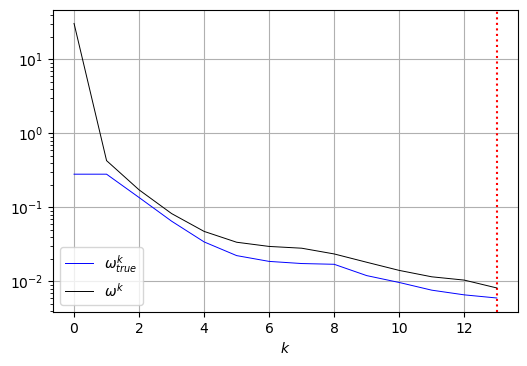

In [20]:
ob.plot_true_rel_gap_uk(lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx)

# Walrasian equilibrium: price directed
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N \underset{x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ) + \nu_1^T E   \\
\mbox{subject to} & \nu_1=\cdots=\nu_N,
\end{array}
$$
where $U_i(x_i)= \mbox{geomean} \left(A_ix_i+b_i\right)$.

## OSBDO oracle-structured form 

We can solve the problem in the dual variable using OSBDO, by taking the agent function
$$
f_i(\nu_i) = \underset{E \geq x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ),
$$
and $g$ the indicator function for consensus plus the total price for all  commodities,
$$
g(x) = \left\{ \begin{array}{ll}  \nu_1^T E & \nu_1 = \cdots = \nu_N\\
\infty & \mbox{otherwise}. 
\end{array}\right.
$$
Note that $f_i$ is convex as a pointwise supremum over linear functions in $\nu_i$.

In [21]:
class GeoMeanConj(ob.Agent):
    """
    fi(nu_i)  = \max_{E\geq x_i\geq 0} ( U_i(x_i) - \nu_i^Tx_i )
    """
    def _construct_params(self):
        self.A = self.params['A']
        self.b = self.params['b']
        self.E = self.params['E']
        self.nu_max = self.params['nu_max']

    def query(self, *, v, solver='ECOS'):
        x = cp.Variable((self.dim), nonneg=True)
        f = cp.geo_mean(self.A @ x + self.b) - v @ x
        prob = cp.Problem(cp.Maximize(f), [x <= self.E])
        prob.solve(solver=cp.MOSEK)
        f = f.value
        q = -x.value
        return ob.Point(x=v, q=q, f=f)
    
    def get_init_minorant(self):
        lwb = stats.mstats.gmean(self.b, axis=None) - self.E @ self.nu_max
        return cp.Constant(lwb)
    
def get_total_obj(agents, xs):
    obj = 0
    for agent in agents:
        obj += stats.mstats.gmean(agent.A @ xs[i] + agent.b, axis=None)
    return -obj

# $\nu \geq 0$

### Create agents

In [22]:
agents = [0]*N
nu_params = []
for i  in  range(N): 
    nu_params += [{ 'dimension':n, 
                    'lower_bound':0, 
                    'upper_bound':None,
                    'nu_max':nu_upb,
                    'E':E,
                    'A':params[i]["A_list"][0],
                    'b':params[i]["b_list"][0]}]
    
    agents[i] = GeoMeanConj(nu_params[i])

In [23]:
domain = [agents[0].x == agent.x for agent in agents[1:]]

g = ob.Coupling(agents = agents, function = agents[0].x @ E, domain = domain)

In [24]:
prob = ob.Problem(agents = agents, g = g)

# OSBDO solution

In [25]:
start = time.time()
x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=50, \
                               solver="OSQP")
print(f"elapsed time =  {time.time()-start}")

k=0, rel_gap=inf, L=-409888.9449481404, U=10014.126129272703
k=1, rel_gap=inf, L=-401456.4859205848, U=10014.126129272703
k=2, rel_gap=inf, L=-385280.7451810157, U=4360.844388614412
k=3, rel_gap=inf, L=-375975.6033661573, U=4360.844388614412
k=4, rel_gap=inf, L=-368674.07414525066, U=4360.844388614412
k=5, rel_gap=14.77585167516818, L=276.4252909070231, U=4360.844388614412
k=6, rel_gap=6.853321015081985, L=300.8179923811784, U=2362.420261281881
k=7, rel_gap=3.726545680091909, L=307.5268189332859, U=1453.5395575415291
k=8, rel_gap=2.196687843699184, L=316.3772204019875, U=1011.3592144823708
k=9, rel_gap=1.3786873520245662, L=330.84014740135154, U=786.9652741655381


/Users/parshakova.tanya/opt/anaconda3/envs/py38/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


k=10, rel_gap=0.7162815334755341, L=341.3037452564218, U=585.7733152896346
k=11, rel_gap=0.46813894734851497, L=353.641316109227, U=519.1945895715439
k=12, rel_gap=0.3071965106060116, L=378.31384227844393, U=494.53053454033494
k=13, rel_gap=0.030786921737716834, L=434.10042453946403, U=447.46504033607016
k=14, rel_gap=0.007772105638673326, L=438.70759103648436, U=442.1172727785078
elapsed time =  105.71737909317017


# $L^k, \quad h^\star, \quad U^k$

In [26]:
prob.lower_bnd[-1], -h_cvx, prob.upper_bnd[-1]

(438.70759103648436, 441.2143119803273, 442.1172727785078)

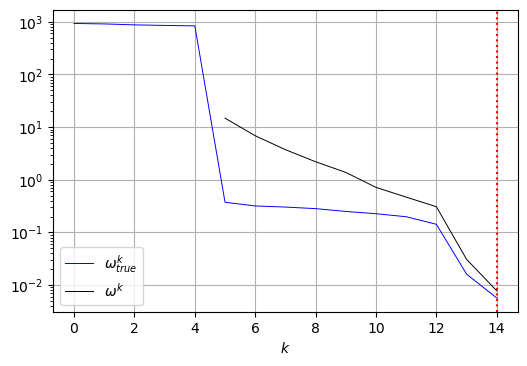

In [27]:
ob.plot_true_rel_gap_uk(lk = -np.array(prob.upper_bnd), uk = -np.array(prob.lower_bnd), h_true = h_cvx)

#  $0 \leq \nu \leq \nu_{\max}$

### Create agents

In [28]:
agents = [0]*N
nu_params = []
for i  in  range(N): 
    nu_params += [{ 'dimension':n, 
                    'lower_bound':0, 
                    'upper_bound':nu_upb,
                    'nu_max':nu_upb,
                    'E':E,
                    'A':params[i]["A_list"][0],
                    'b':params[i]["b_list"][0]}]
    
    agents[i] = GeoMeanConj(nu_params[i])

In [31]:
domain = [agents[0].x == agent.x for agent in agents[1:]]

g = ob.Coupling(agents = agents, function = agents[0].x @ E, domain = domain)

In [32]:
prob = ob.Problem(agents = agents, g = g)

# OSBDO solution

In [35]:
start = time.time()
x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=50)
print(f"elapsed time =  {time.time()-start}")

k=0, rel_gap=inf, L=-409888.94494813966, U=4199.257903357693


/Users/parshakova.tanya/opt/anaconda3/envs/py38/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


k=1, rel_gap=41.10016572231153, L=99.74445067640771, U=4199.257903357693
k=2, rel_gap=21.535412641569838, L=186.34040432929783, U=4199.257903357693
k=3, rel_gap=16.228680048598118, L=186.97809631974368, U=3221.385797588825
k=4, rel_gap=10.317407912209807, L=217.92716953629804, U=2466.370672795588
k=5, rel_gap=7.131186261921752, L=245.6762239255546, U=1997.6391368642817
k=6, rel_gap=5.388721531878714, L=277.6708122573816, U=1773.9614970429857
k=7, rel_gap=3.6650860304222608, L=288.6542631602767, U=1346.596970690838
k=8, rel_gap=3.0556735108352933, L=307.0382059729114, U=1245.2467187787274
k=9, rel_gap=2.7302754106800102, L=326.195321068196, U=1216.7983852595626
k=10, rel_gap=1.5542036817711382, L=336.7268451540979, U=860.0689476437767
k=11, rel_gap=1.3759639678527502, L=361.9873698762587, U=860.0689476437767
k=12, rel_gap=1.3228190844306298, L=361.9873698829687, U=840.8311710870091
k=13, rel_gap=0.9812080321491362, L=369.62285690963273, U=732.2997729752752
k=14, rel_gap=0.92608394475842

# $L^k, \quad h^\star, \quad U^k$

In [36]:
prob.lower_bnd[-1], -h_cvx, prob.upper_bnd[-1]

(439.8213597442968, 441.2143119803273, 441.847839695933)

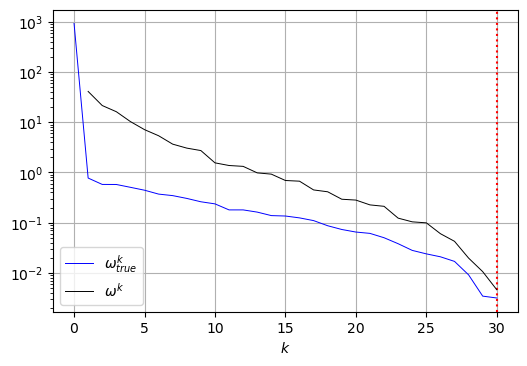

In [37]:
ob.plot_true_rel_gap_uk(lk = -np.array(prob.upper_bnd), uk = -np.array(prob.lower_bnd), h_true = h_cvx)